## Realistic Problem

In [42]:
# Importing Libraries
import pandas as pd
import math
import networkx as nx
import random
from itertools import combinations

# Load the actual dataset
df = pd.read_csv('illinois.csv')

# Defining the Haversine Function to calculate distances
def haversine(x,y): # Code taken from https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    lon1=x[0]
    lat1=x[1]
    lon2=y[0]
    lat2=y[1]
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 3956 # This value does *not* affect the spanning tree calculations! 
    # It is the radius of the earth (needed for the Haversine calculation) in miles. It would be 6371 for kilometers. 
    return c*r

# Preparing Data and Creating a Graph
x=df["longitude"].tolist() # Longitude corresponds to the x axis.
y=df["latitude"].tolist() # Latitude corresponds to the y axis.
z=df["zip_code"].tolist() # getting all zip codes
# Getting them in list form ensures we can access them all at the same time with the same index.
# For example x[101], y[101], and z[101] would all return the 102nd zip code's longitude, latitude, and zip code value.
zipcodes={}
pos={}
for i in range(len(x)):
    zipcodes[z[i]]=(x[i],y[i]) # storing (x,y) information for each zip code
    pos[z[i]]=(x[i],y[i]) # also storing them to position the nodes in the end.
    # Fixing the position of the nodes in the graph makes for a more "realistic" plot of Illinois!
    # Unnecessary, but looks nice (when we plot).

G=nx.Graph() 
addList=[]
for (i,j) in combinations(zipcodes,2):
    distance=haversine(zipcodes[i],zipcodes[j])
    addList.append(distance)
    G.add_edge(i,j,weight=distance) # creating the graph one pair of zip codes at a time

## Steiner Tree

In [82]:
# Import libraries
import heapq as hq

In [83]:
# Minimum cost steiner tree
def minimum_cost_steiner_tree(G, terminal_nodes):
    tree=nx.Graph()
    
    ### First, check for extreme cases:
    ### 1. if there are no terminal nodes to connect, then return the empty graph.
    ### 2. If there is only one terminal node, then return a singleton node.
    ### In any other case, we go to the else statement!
    if len(terminal_nodes)==0:
        return tree
    elif len(terminal_nodes)==1:
        tree.add_node(terminal_nodes[0])
        return tree
    else:
        # Create a heap
        myHeap = []
        myPaths = {}
        for i in range(len(terminal_nodes) - 1):
            ### The next few lines print a statement -- useful to monitor progress in large networks.
#             a=float(i)/float(len(terminal_nodes)-1)*100
#             print("%.1f" % a+"% completed")
            n1 = terminal_nodes[i]
            for n2  in terminal_nodes[i+1:]: 
                # For each pair of nodes, we calculate the shortest path between the two.
                path = nx.bidirectional_dijkstra(G, n1, n2) # path is a tuple: the first element is the distance, the second the nodes it contains
                if path == False: # if the path is not there, something is wrong!
                    terminal_nodes.remove(n2) # To solve the issue, remove the second node, print an error message, and continue
                    continue # THIS SHOULD NEVER HAPPEN! It is simply here to catch a problem with the setup.
                nodelist=path[1]
                distance=path[0]
                # Get the pair we are considering
                pair=[n1,n2]
                # Sort it (so that all terminals are from lower to higher value)
                pair.sort()
                # And push the shortest path and its distance in the heap
                myPaths["%s%s", pair[0], pair[1]]=nodelist
                hq.heappush(myHeap, (distance, pair))
        # When we have all the shortest paths, check the heap and start taking them out, cheapest one first.
        while myHeap:
            myItem=hq.heappop(myHeap)
            # This appears convoluted, but it essentially states that we will add edges to the network, 
            # if i) it is not already there, and ii) it does not form a cycle. 
            if myItem[1][0] not in tree or myItem[1][1] not in tree or not nx.has_path(tree, myItem[1][0], myItem[1][1]):
                tree.add_edge(myItem[1][0], myItem[1][1], weight=myItem[0])
        subgraph=nx.Graph()
        # For all the tree edges, add them in a new subgraph
        for e in tree.edges(data=True):
            pair = [e[0],e[1]]
            pair.sort()
            newList = myPaths["%s%s", pair[0], pair[1]]
            for i in range(len(newList) - 1):
                subgraph.add_edge(newList[i], newList[i+1])
                
        # Return the subgraph's minimum spanning tree
        subgraph = nx.minimum_spanning_tree(subgraph)
        return subgraph

In [84]:
# Displaying terminal nodes
terminal_nodes = [60629, 60618, 60632, 60647, 60639, 60804, 60617, 60608, 60625, 60623]
terminal_nodes

[60629, 60618, 60632, 60647, 60639, 60804, 60617, 60608, 60625, 60623]

In [85]:
# Get steiner tree
steiner_tree = minimum_cost_steiner_tree(G,terminal_nodes)

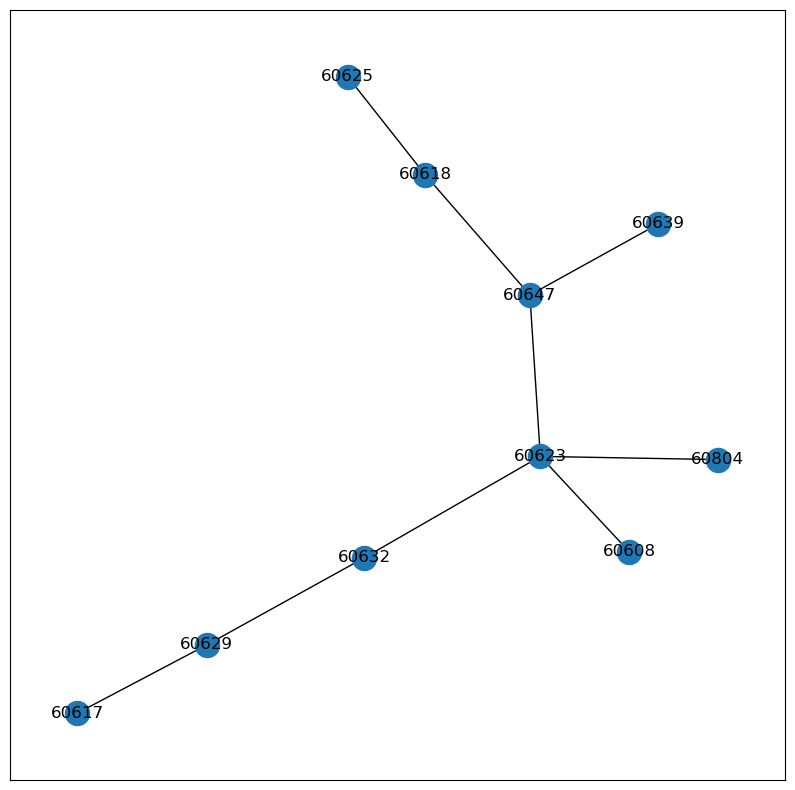

In [108]:
# Steiner tree visualization
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10] ## set the size of all figures

nx.draw_networkx(steiner_tree)
plt.savefig("../../Plots/Illinois_Steiner_Tree_Graph.png", format="PNG")

In [109]:
# Calculate the time each node gets to the closest vertice in spanning tree
# Nodes not in Steiner tree
non_steiner_nodes = set(G.nodes()) - set(steiner_tree.nodes())

# Calculate shortest paths and their lengths
shortest_paths_lengths = []
for i in non_steiner_nodes:
    shortest_length_to_steiner = min(nx.shortest_path_length(G, source=i, target=j, weight='weight') 
                                     for j in steiner_tree.nodes)
    shortest_paths_lengths.append(shortest_length_to_steiner)

# Sum and average of the shortest paths lengths
sum_of_shortest_paths = sum(shortest_paths_lengths)
average_shortest_path_length = sum_of_shortest_paths / len(shortest_paths_lengths) if shortest_paths_lengths else 0

# Display the results
print("Sum of Shortest Paths:", sum_of_shortest_paths)
print("Average Shortest Path Length:", average_shortest_path_length)


Sum of Shortest Paths: 186616.84147599284
Average Shortest Path Length: 134.6441857691146
